# Cats vs Dogs Predictor


In this lab, I will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        #print('labels: ',labels)
        #print('corr: ',corr)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a)

Visualize some of the data by running the code below.

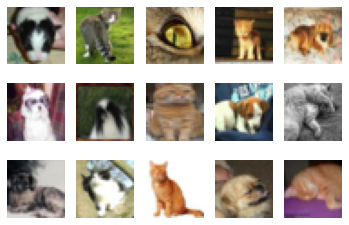

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b)

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print('Training examples: {}'.format(len(train_loader)))
print('Validation examples: {}'.format(len(val_loader)))
print('Test examples: {}'.format(len(test_loader)))

Training examples: 8000
Validation examples: 2000
Test examples: 2000


### Part (c)

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Answer:** The purpose of the validation set is to tune the parameters such as the batch size and learning rate (after testing on the validation set).

Models are not suppoesd to be tested on the training sets because the training sets are where they are "trained" on. Testing too much on a training set (and adjusting the hyperparameters so that the errors  for *just* the training set approach 0) can lead to overfitting, as the model will be too fixed on the training set that it won't be able to generalize to unseen data.

## Part 2. Training

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a)

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`?

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


Multiply numbers within each size tensor, add up results:

(5 * 3* 3* 3)+(5)+(1 *245)+(1)=386

**Answer:** Total number of parameters = 386

In [ ]:
for param in large_net.parameters():
  print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


Multiply numbers within each size tensor, add up results:

(5 * 3 * 5 * 5)+5+(10 * 5 * 5 * 5)+10+(32 * 250)+32+(1 * 32)+1=9705

**Answer:** Total number of parameters = 9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            print('outputs: ',outputs)
            print('labels: ',labels)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            '''corr = (outputs > 0.0)
            print(corr)
            print(len(corr))
            print(len(labels))'''
            corr = (outputs > 0.0)     #25 19 39 20
            #print('1: ',int(corr.sum()))
            corr = (outputs > 0.0).squeeze().long() != labels
            #print('2: ',int(corr.sum()))
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b)
The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
#batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c)

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
#info in file: train error, train loss, validation error, validation loss
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=1)

Files already downloaded and verified
Files already downloaded and verified
outputs:  tensor([-2.4240e+00,  4.9929e-02, -1.0755e+00, -3.8307e-01, -1.4180e+00,
        -4.3249e-01,  4.1209e-01, -8.4506e-01, -1.8407e+00, -6.1306e-01,
        -2.2661e-01,  1.7625e+00,  1.9365e-01,  4.1975e-01,  1.7808e+00,
         4.1860e-01,  2.9817e-01, -3.7793e-01,  4.0297e-01,  8.6277e-02,
         3.7349e-01,  4.5105e-01, -4.5838e-01, -3.1778e-01,  6.9686e-01,
        -1.0455e+00,  7.2845e-01, -1.4159e+00,  3.3278e-01,  1.2476e-01,
         1.0102e-01,  2.6566e-01, -2.3795e-01,  1.2806e+00,  1.1481e-01,
         6.4083e-01, -1.4398e+00,  1.8550e-01,  9.0753e-02,  2.3183e-01,
        -3.6717e-01,  1.7197e+00,  8.2277e-01,  1.6862e+00,  6.4106e-01,
        -1.3685e+00, -1.2245e+00,  3.0912e+00, -1.0104e+00, -3.6802e-01,
         2.5947e-01, -6.4409e-01, -8.5184e-01, -1.1515e+00, -1.5883e+00,
        -3.9745e-01, -3.0049e-03, -7.9816e-01,  4.0024e-01,  5.2352e-02,
        -4.0114e-01,  4.5888e-01,  5.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Part (d)

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.32575, Train loss: 0.602990318775177 |Validation err: 0.3355, Validation loss: 0.6173910796642303
Epoch 2: Train err: 0.316875, Train loss: 0.5949750926494598 |Validation err: 0.343, Validation loss: 0.6338571757078171
Epoch 3: Train err: 0.311375, Train loss: 0.5893620898723603 |Validation err: 0.329, Validation loss: 0.6057337634265423
Epoch 4: Train err: 0.306625, Train loss: 0.5852861063480377 |Validation err: 0.3395, Validation loss: 0.6099948566406965
Epoch 5: Train err: 0.304375, Train loss: 0.5815669634342193 |Validation err: 0.3195, Validation loss: 0.60984668135643
Epoch 6: Train err: 0.307375, Train loss: 0.5787903413772583 |Validation err: 0.325, Validation loss: 0.6040217457339168
Epoch 7: Train err: 0.30525, Train loss: 0.5752578880786896 |Validation err: 0.3345, Validation loss: 0.5994179360568523
Epoch 8: Train err: 0.29575, Train loss: 0.5714053030014038 |Validation err: 0

In [ ]:
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.487125, Train loss: 0.6924404425621032 |Validation err: 0.4405, Validation loss: 0.6897194758057594
Epoch 2: Train err: 0.450125, Train loss: 0.6873318748474121 |Validation err: 0.4175, Validation loss: 0.6810790542513132
Epoch 3: Train err: 0.424125, Train loss: 0.6747903661727905 |Validation err: 0.3885, Validation loss: 0.6569829937070608
Epoch 4: Train err: 0.38075, Train loss: 0.6508827657699585 |Validation err: 0.369, Validation loss: 0.6457093469798565
Epoch 5: Train err: 0.357125, Train loss: 0.637935616493225 |Validation err: 0.3615, Validation loss: 0.6340117380023003
Epoch 6: Train err: 0.343625, Train loss: 0.6251359066963196 |Validation err: 0.3455, Validation loss: 0.627953790128231
Epoch 7: Train err: 0.338375, Train loss: 0.6143229374885559 |Validation err: 0.3415, Validation loss: 0.6194543763995171
Epoch 8: Train err: 0.325125, Train loss: 0.6026482799053192 |Validation e

**Answer:** The large_net network took longer to train (122.40 seconds), whereas the small_net network took 107.56 seconds.

The large_net network took longer because it has more layers than small_net. 

### Part (e)

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

In [ ]:
model_path=get_model_name('small', batch_size=64, learning_rate=0.01, epoch=29)

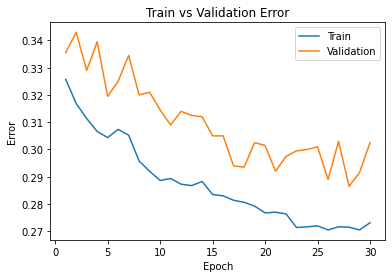

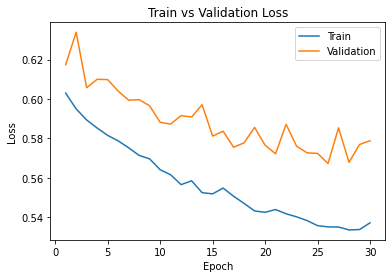

In [ ]:
plot_training_curve(model_path)

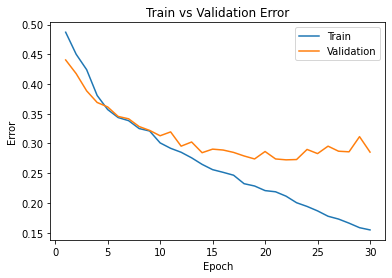

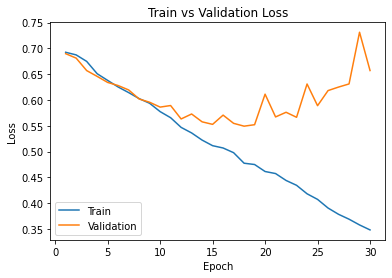

In [ ]:
model_path_2=get_model_name('large', batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_2)

### Part (f)

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The large_net curve goes through overfitting. This is evident as initially, the validation error/loss curve closely follows the training error/loss curve. However, with more iterations, the model eventually gets too trained/fixed on the training data, that it is unable to generalize to unseen data. This results in the validation error/loss plateauing or  increasing with each epoch. 

The small_net curve goes through underfitting as the training loss/errors are already pretty high (that you can't really expect them to do well on the validation). This means that the training dataset needs to go through more intensive training; for example, it may need to go through more iterations to further train itself on the training data. 

## Part 3. Optimization Parameters

For this section, we will work with `large_net` only.

### Part (a)

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

**Answer:** Takes longer to train. This is because since the learning rate is smaller, then when it gets multiplied, the value of the "steps" are lower. With smaller "steps" towards minimum error, it takes longer to train.


In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.497375, Train loss: 0.6937690386772156 |Validation err: 0.5075, Validation loss: 0.6932747140526772
Epoch 2: Train err: 0.481, Train loss: 0.6923328990936279 |Validation err: 0.459, Validation loss: 0.6914442852139473
Epoch 3: Train err: 0.451875, Train loss: 0.6911920099258423 |Validation err: 0.437, Validation loss: 0.6901759058237076
Epoch 4: Train err: 0.441125, Train loss: 0.6901091275215149 |Validation err: 0.441, Validation loss: 0.6883849408477545
Epoch 5: Train err: 0.43825, Train loss: 0.6889482131004333 |Validation err: 0.431, Validation loss: 0.6872975062578917
Epoch 6: Train err: 0.4375, Train loss: 0.6876590156555176 |Validation err: 0.422, Validation loss: 0.6856152843683958
Epoch 7: Train err: 0.433875, Train loss: 0.6862158465385437 |Validation err: 0.4185, Validation loss: 0.6838120464235544
Epoch 8: Train err: 0.42975, Train loss: 0.6845459523200988 |Validation err: 0.42

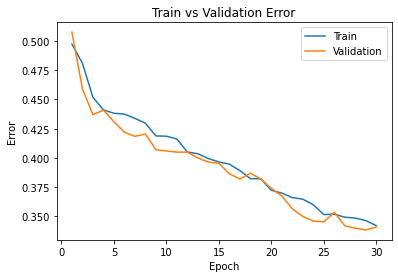

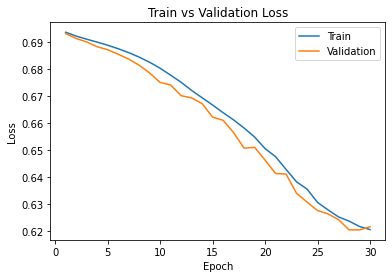

In [ ]:
model_path_3=get_model_name('large', batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_3)

### Part (b)

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

**Answer:** It took longer to train. Usually, increasing the learning rate results in larger "steps" which should decrease the training time. However, this is not always the case. If the learning rate is TOO large, then the steps can "criss-cross" while undergoing gradient descent. This "criss-crossing" is evident in the graphs as the curves are very "jagged" and noisy. They are alternating between higher and lower error values.

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

'''takes longer time to train'''

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44425, Train loss: 0.6838377194404602 |Validation err: 0.417, Validation loss: 0.6798075009137392
Epoch 2: Train err: 0.387, Train loss: 0.6591065440177918 |Validation err: 0.384, Validation loss: 0.6421225406229496
Epoch 3: Train err: 0.3665, Train loss: 0.6347824468612671 |Validation err: 0.3605, Validation loss: 0.6413515340536833
Epoch 4: Train err: 0.3535, Train loss: 0.6272764320373535 |Validation err: 0.356, Validation loss: 0.6313397102057934
Epoch 5: Train err: 0.336375, Train loss: 0.6052721109390259 |Validation err: 0.344, Validation loss: 0.6175968777388334
Epoch 6: Train err: 0.317875, Train loss: 0.5929006912708282 |Validation err: 0.3185, Validation loss: 0.6394618432968855
Epoch 7: Train err: 0.31075, Train loss: 0.5770841290950776 |Validation err: 0.359, Validation loss: 0.63242875225842
Epoch 8: Train err: 0.30925, Train loss: 0.5728916997909546 |Validation err: 0.322, Va

'takes longer time to train'

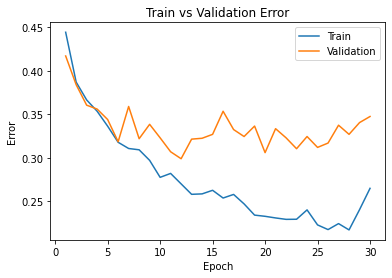

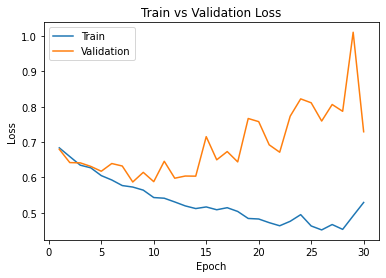

In [ ]:
model_path_4=get_model_name('large', batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_4)

### Part (c)

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

**Answer:** It takes a shorter time to train. This is because larger batches leads to a lower number of iterations. Because the number of iterations is low, the values do not get optimized as much, so the error values are relatively high.

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.469875, Train loss: 0.6909716799855232 |Validation err: 0.453, Validation loss: 0.6904224753379822
Epoch 2: Train err: 0.46425, Train loss: 0.6892555691301823 |Validation err: 0.4505, Validation loss: 0.6891553699970245
Epoch 3: Train err: 0.4555, Train loss: 0.6878202259540558 |Validation err: 0.4465, Validation loss: 0.6878849565982819
Epoch 4: Train err: 0.448875, Train loss: 0.6867033764719963 |Validation err: 0.446, Validation loss: 0.6866987645626068
Epoch 5: Train err: 0.448, Train loss: 0.685115247964859 |Validation err: 0.4425, Validation loss: 0.6855423450469971
Epoch 6: Train err: 0.44475, Train loss: 0.6843021623790264 |Validation err: 0.4395, Validation loss: 0.6843730956315994
Epoch 7: Train err: 0.4425, Train loss: 0.6831371448934078 |Validation err: 0.444, Validation loss: 0.6832610070705414
Epoch 8: Train err: 0.43875, Train loss: 0.6819746196269989 |Validation err: 0.4315

'takes shorter time to train'

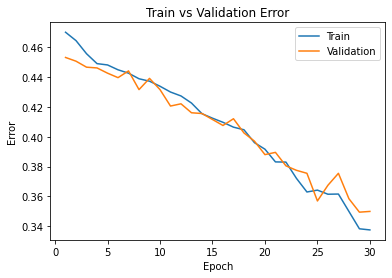

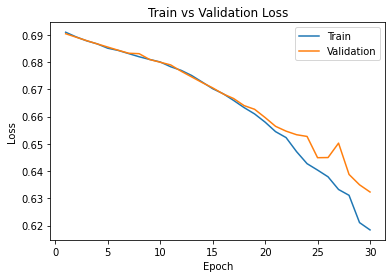

In [ ]:
model_path_5=get_model_name('large', batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_5)

### Part (d)

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

**Answer:** It takes a longer time to train. This is because smaller batch sizes lead to more iterations. However, in this case, the batch size was decreased too much. This is evident due to the overfitting shown in the graphs. Because the number of iterations are too high, the model gets too trained on the training dataset, that the performance on the validation dataset is very poor (its error plateaus, loss increases).

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432375, Train loss: 0.6776111873388291 |Validation err: 0.3685, Validation loss: 0.6501240582466126
Epoch 2: Train err: 0.367875, Train loss: 0.6403644292354583 |Validation err: 0.355, Validation loss: 0.6325501449108124
Epoch 3: Train err: 0.338, Train loss: 0.6096278015375137 |Validation err: 0.326, Validation loss: 0.6031130259037017
Epoch 4: Train err: 0.3195, Train loss: 0.5898999410271645 |Validation err: 0.326, Validation loss: 0.6062264757156373
Epoch 5: Train err: 0.306125, Train loss: 0.5717852766513825 |Validation err: 0.305, Validation loss: 0.5729322798252106
Epoch 6: Train err: 0.2885, Train loss: 0.5537521095871926 |Validation err: 0.3085, Validation loss: 0.5815223565101624
Epoch 7: Train err: 0.276625, Train loss: 0.5346069442629814 |Validation err: 0.306, Validation loss: 0.5928398003578186
Epoch 8: Train err: 0.26825, Train loss: 0.5221896586716175 |Validation err: 0.327

'takes longer time to train'

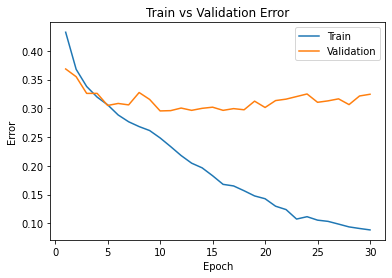

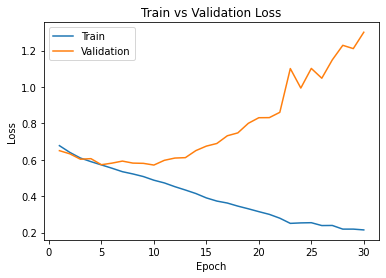

In [ ]:
model_path_6=get_model_name('large', batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_6)

## Part 4. Hyperparameter Search

### Part (a)

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Answer:**

Network: small_net because large_net led to overfitting (as shown in part 2f). Small_net went through underfitting, however that can be fixed with more training (ex: higher number of epochs).

Batch size: 50. A batch size of 16 led to overfitting, and a batch size of 512 do not yield as much accuracy. 

Learning rate: 0.001. A learning rate of 0.1 was too large as discussed in part 2b (led to jagged and noisy curves). A learning rate of 0.001 will result in smaller step sizes which would overall improve the accuracy of the model.

Epochs: 50. Increasing the number of epochs from 30 to 50 will increase the accuracy of the model, as the weights are getting optimized more. Increasing the epochs too much would take too much time and might also lead to overfitting.

### Part (b)

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
small_net=SmallNet()
train_net(small_net, batch_size=50, learning_rate=0.001, num_epochs=50)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.475375, Train loss: 0.691240856796503 |Validation err: 0.452, Validation loss: 0.6871955469250679
Epoch 2: Train err: 0.443625, Train loss: 0.6858992900699377 |Validation err: 0.4125, Validation loss: 0.6817104458808899
Epoch 3: Train err: 0.422375, Train loss: 0.6804862823337317 |Validation err: 0.396, Validation loss: 0.6751382157206536
Epoch 4: Train err: 0.409, Train loss: 0.674124614149332 |Validation err: 0.381, Validation loss: 0.6673330768942833
Epoch 5: Train err: 0.394125, Train loss: 0.6670164801180363 |Validation err: 0.3715, Validation loss: 0.6600121185183525
Epoch 6: Train err: 0.3785, Train loss: 0.6592078074812889 |Validation err: 0.366, Validation loss: 0.6533252909779549
Epoch 7: Train err: 0.36725, Train loss: 0.6521181799471378 |Validation err: 0.3615, Validation loss: 0.6481052815914154
Epoch 8: Train err: 0.358875, Train loss: 0.6457514334470034 |Validation err: 0.35

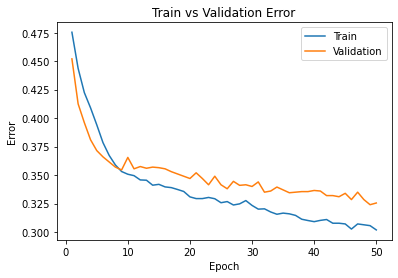

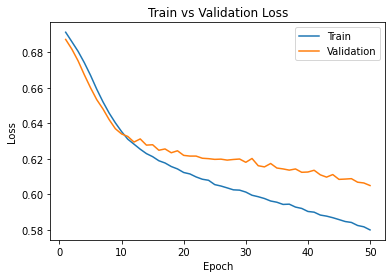

In [ ]:
model_path_7=get_model_name('small', batch_size=50, learning_rate=0.001, epoch=49)
plot_training_curve(model_path_7)

### Part (c)

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

**Answer:**

Network: small_net because large_net led to overfitting (as shown in part 2f). Small_net went through underfitting, however that can be fixed with more training (ex: higher number of epochs).

Batch size: 200. A batch size of 16 led to overfitting, and a batch size of 512 do not yield as much accuracy. Also, to shorten the time, as having a batch size of 50 from the previous question took about 3 minutes to train. 

Learning rate: 0.01. A learning rate of 0.1 was too large as discussed in part 2b (led to jagged and noisy curves). A learning rate of 0.001 led to the model taking about 3 minutes to train. A learning rate of 0.01 will give the smaller step sizes (which would overall improve the accuracy of the model) but also reduce the time to train.

Epochs: 70. Increasing the number of epochs from 30 to 70 will increase the accuracy of the model, as the weights are getting optimized more. Increasing the epochs too much would take too much time and might also lead to overfitting.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
small_net=SmallNet()
train_net(small_net, batch_size=200, learning_rate=0.01, num_epochs=70)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.450375, Train loss: 0.6869083598256112 |Validation err: 0.398, Validation loss: 0.6757920920848847
Epoch 2: Train err: 0.403375, Train loss: 0.6704838186502456 |Validation err: 0.394, Validation loss: 0.666199904680252
Epoch 3: Train err: 0.384, Train loss: 0.6591653674840927 |Validation err: 0.3755, Validation loss: 0.6540130853652955
Epoch 4: Train err: 0.368375, Train loss: 0.6493516311049461 |Validation err: 0.373, Validation loss: 0.6469931066036224
Epoch 5: Train err: 0.36275, Train loss: 0.6425068497657775 |Validation err: 0.3825, Validation loss: 0.6466545581817627
Epoch 6: Train err: 0.36175, Train loss: 0.639259611070156 |Validation err: 0.375, Validation loss: 0.6425134539604187
Epoch 7: Train err: 0.356, Train loss: 0.6349740654230118 |Validation err: 0.366, Validation loss: 0.6405929207801819
Epoch 8: Train err: 0.3545, Train loss: 0.6320874601602554 |Validation err: 0.3665, V

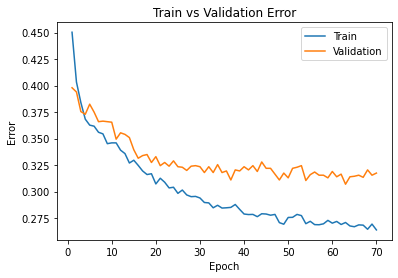

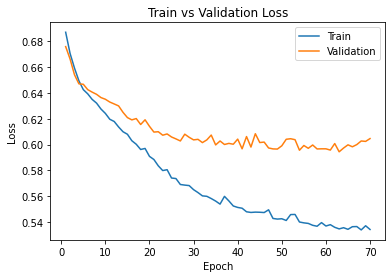

In [ ]:
model_path_8=get_model_name('small', batch_size=200, learning_rate=0.01, epoch=69)
plot_training_curve(model_path_8)

## Part 4. Evaluating the Best Model


### Part (a)

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=50, learning_rate=0.001, epoch=49)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b)

Justify your choice of model from part (a).

I chose the first model (4a,4b). 

From the graph of the second model (4c,4d), it can be seen from the graph that the model undergoes a lot of variation, as can be seen from the many jagged lines (the "noise"). This is possible due to the higher learning rate, which may result in a faster gradient descent and hence "criss-crossing" between higher errors and lower errors. Also, in the second model, there is a lot of difference between the training performance curves and the validation performance curves (especially in the loss graph). This shows that the model might have been over-trained on the training dataset, so that the model performs really well on the training set, but it cannot perform as effectively on unseen data (validation set).

### Part (c)

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

**Answer:** Test classification error: 0.3395

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
criterion = nn.BCEWithLogitsLoss()

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=50)

evaluate(net, test_loader, criterion)

Files already downloaded and verified
Files already downloaded and verified


(0.3395, 0.6111089006066323)

### Part (d)

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**Answer:** The test classification error (0.3395) is higher than the validation error (0.3255) as expected. This is because the validation error values were used many times to tune the hyperparameters. The hyperparameter tuning was based off of validation errors, so that the validation error can be minimized. The testing data is the final data that is tested on only once, as a "final assessment." In other words, it is new/unseen data that the weights and hyperparameters were not optimized on. 

### Part (e)

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer:** The whole point of "testing" the model is to first make the model as best as possible through training it on the training dataset, and then testing on the validation dataset (to tune the hyperparamaters). After tuning the hyperparameters, you train the model again, and test it on the validation dataset. The process of tuning hyperparameters was pretty iterative, but the point was to find the hyperparameters that help the model best "fit" our data. 

Once the hyperparameters are tuned and our model gives us decently accurate results for our validation, then we can move forward and test on our testing data, to get a sort of "final assessment" of our model's performance. 

### Part (f)

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name='pigeon'
        self.layer1 = nn.Linear(32*32*3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened=img.view(-1,32*32*3)
        #flattened = img.view(-1, 28 * 28)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2=activation2.squeeze(1)
        return activation2

pigeon = Pigeon()

In [ ]:
train_net(pigeon, batch_size=50, learning_rate=0.001, num_epochs=50)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.424125, Train loss: 0.6765133921056986 |Validation err: 0.406, Validation loss: 0.6641246497631073
Epoch 2: Train err: 0.392625, Train loss: 0.6578669287264347 |Validation err: 0.3955, Validation loss: 0.6582182571291924
Epoch 3: Train err: 0.383125, Train loss: 0.6495488565415144 |Validation err: 0.39, Validation loss: 0.6539323672652244
Epoch 4: Train err: 0.37475, Train loss: 0.6431181199848652 |Validation err: 0.3895, Validation loss: 0.6565394937992096
Epoch 5: Train err: 0.373375, Train loss: 0.63886325545609 |Validation err: 0.384, Validation loss: 0.6499674767255783
Epoch 6: Train err: 0.362625, Train loss: 0.6331426028162241 |Validation err: 0.3855, Validation loss: 0.6496291026473046
Epoch 7: Train err: 0.357875, Train loss: 0.6293457925319672 |Validation err: 0.381, Validation loss: 0.6481462001800538
Epoch 8: Train err: 0.351375, Train loss: 0.6247547954320908 |Validation err: 

In [ ]:
evaluate(pigeon, test_loader, criterion)

(0.3575, 0.690567034482956)

**Conclusion:** The CNN was more accurate than the ANN, as the testing and validation errors for the CNN were lower. However, the training error for the ANN was lower than the training error for the CNN. Despite this, the CNN would still be considered to exhibit higher performance, as models are supposed to be evaluated based on their validation and testing performances. It is possible that for the ANN, the model got too "fixed" or trained on the training dataset, that it was not able to generalize to unseen data as effectively.